In [24]:
import dataclasses
import datetime
import s3fs
import xarray as xr
import numpy as np
import metpy
from metpy.units import units
from metpy.calc import (dewpoint_from_specific_humidity, equivalent_potential_temperature)
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature
projection = ccrs.LambertConformal(central_longitude=262.5, 
                                   central_latitude=38.5, 
                                   standard_parallels=(38.5, 38.5),
                                    globe=ccrs.Globe(semimajor_axis=6371229,semiminor_axis=6371229))

In [25]:
@dataclasses.dataclass
class ZarrId:
    run_hour: datetime.datetime
    level_type: str
    var_level: str
    var_name: str
    model_type: str
        
    def format_chunk_id(self, chunk_id):
        if self.model_type == "fcst": 
            # Extra id part since forecasts have an additional (time) dimension
            return "0." + str(chunk_id)
        else:
            return chunk_id
        
#CHUNKS FOR 5/22: 2.5, 2.6, 3.5, 3.6

fs = s3fs.S3FileSystem(anon=True) 

def load(url, run_hour=None, new_time_dimension=None):
    # Download the data from S3. May be lazy.
    ds = xr.open_dataset(s3fs.S3Map(url, s3=fs), engine="zarr")
    
    # Add the model run hour in as a dimension
    if run_hour is not None:
        ds[new_time_dimension] = run_hour
        ds = ds.set_coords(new_time_dimension)
    
    # Later on we use metpy functions that expect the grid variables to be x and y
    ds = ds.rename(projection_x_coordinate="x", projection_y_coordinate="y")
    return ds

def load_combined_dataset(zarr_ids):
    
    # Get the grid data (at a long forecast hour in case the whole time dim is needed)
    grid_zarr_id = dataclasses.replace(zarr_ids[0]) # dataclasses.replace is just a fancy copy function
    grid_zarr_id.run_hour = grid_zarr_id.run_hour.replace(hour=0)  
    grid = load(create_s3_group_url(grid_zarr_id))
    
    is_forecast = zarr_ids[0].model_type == "fcst"
    new_time_dimension = "reference_time" if is_forecast else "time"
    
    datasets = [load(create_s3_subgroup_url(zarr_id), zarr_id.run_hour, new_time_dimension) 
                for zarr_id in zarr_ids]
    
    if is_forecast: # Align the time axes of each dataset (b/c forecasts have different lengths)
        for dataset in datasets:
            dataset["time"] = grid["time"][:len(dataset["time"])]
        datasets = xr.align(*datasets, join="outer")
        
    ds = xr.concat(datasets, dim=new_time_dimension, combine_attrs="override")
    
    # Add the geospatial data to the combined dataset
    ds["x"] = grid["x"]
    ds["y"] = grid["y"]  
    ds = ds.metpy.assign_crs(projection.to_cf())
    ds = ds.metpy.assign_latitude_longitude()
    
    return ds

def create_s3_group_url(zarr_id, prefix=True):
    url = "s3://hrrrzarr/" if prefix else "" # Skip when using boto3
    url += zarr_id.run_hour.strftime(
        f"{zarr_id.level_type}/%Y%m%d/%Y%m%d_%Hz_{zarr_id.model_type}.zarr/")
    url += f"{zarr_id.var_level}/{zarr_id.var_name}"
    return url

def create_s3_subgroup_url(zarr_id, prefix=True):
    url = create_s3_group_url(zarr_id, prefix)
    url += f"/{zarr_id.var_level}"
    return url

def create_s3_chunk_url(zarr_id, chunk_id, prefix=False):
    url = create_s3_subgroup_url(zarr_id, prefix)
    url += f"/{zarr_id.var_name}/{zarr_id.format_chunk_id(chunk_id)}"
    return url

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

Ignoring index file 'hrrr.t23z.wrfnatf00.grib2.923a8.idx' older than GRIB file


hrrr.t23z.wrfnatf00.grib2 



D:\Anaconda3\envs\THESIS\lib\site-packages\metpy\calc\thermo.py:1341: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')
D:\Anaconda3\envs\THESIS\lib\site-packages\metpy\calc\thermo.py:1384: RuntimeWarning: divide by zero encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)
D:\Anaconda3\envs\THESIS\lib\site-packages\metpy\calc\thermo.py:1385: RuntimeWarning: invalid value encountered in divide
  return mpconsts.nounit.zero_degc + 243.5 * val / (17.67 - val)


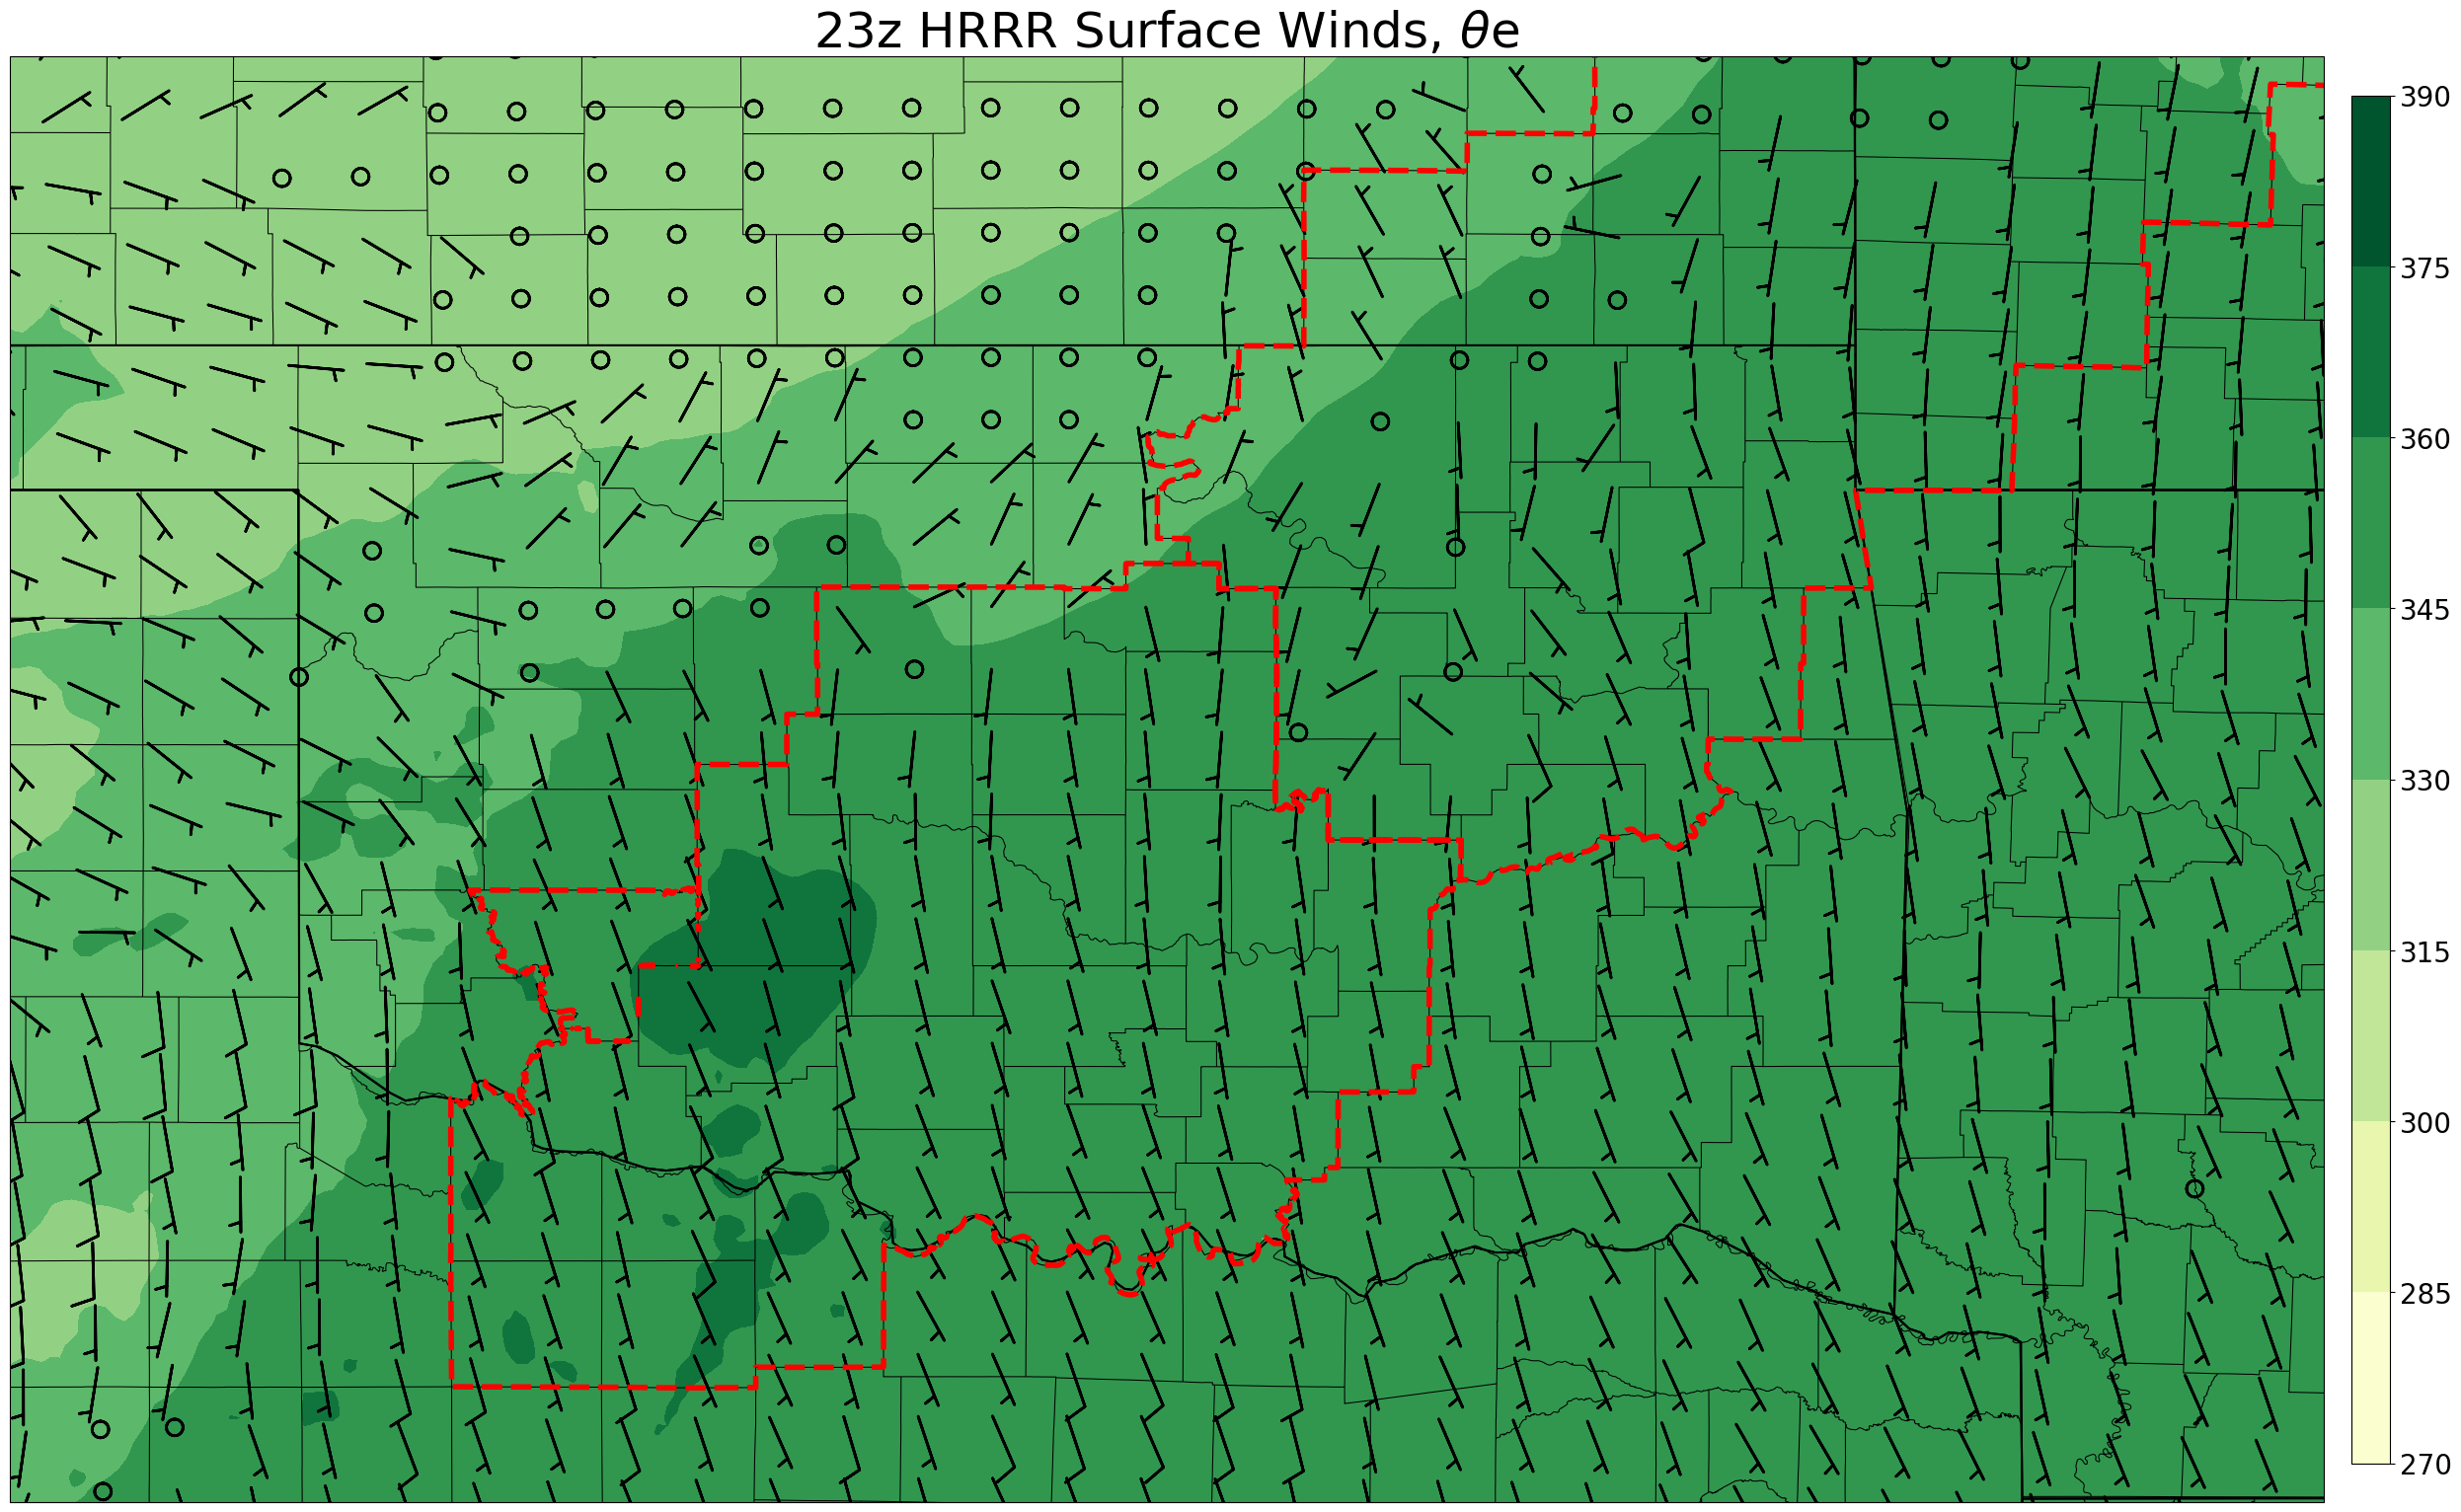

In [26]:
year=2019
month=5
day = 22
hour = 23
##############################
run_hour=datetime.datetime(year, month, day, hour)
zarr_ids = [ZarrId(
                run_hour=datetime.datetime(year, month, day, hour) + datetime.timedelta(hours=time_delta),
                level_type="sfc",
                var_level="entire_atmosphere",
                var_name="REFC",
                model_type="anl"
                )
            for time_delta in range(3)] # get 3 hours starting at the given time

dat = load_combined_dataset(zarr_ids)

Hour = hour

time_start = datetime.datetime(int(year), int(month), int(day), int(hour), 0) # Our specified time
hour = time_start.hour
if hour < 10:
    hour = '0'+str(hour)
else:
    hour=str(hour)
day = time_start.day
if day < 10:
    day = '0'+str(day)
else:
    day=str(day)
month = time_start.month
if month < 10:
    month = '0'+str(month)
else:
    month=str(month)
year=str(year)

timeIN=str(year+month+day)

fs = s3fs.S3FileSystem(anon=True)
#fs.ls('s3://noaa-hrrr-bdp-pds/hrrr.20190522/conus/')
files = np.array(fs.ls('s3://noaa-hrrr-bdp-pds/hrrr.'+timeIN+'/conus/'))
fileN = np.where(files=='noaa-hrrr-bdp-pds/hrrr.'+timeIN+'/conus/hrrr.t'+hour+'z.wrfnatf00.grib2')
fs.get(files[fileN[0][0]], files[fileN[0][0]].split('/')[-1])
fname=files[fileN[0][0]].split('/')[-1]
c=xr.open_dataset(fname, filter_by_keys={'typeOfLevel': 'hybrid'})
print(fname, "\n")

lev=np.asarray(c.variables['hybrid'][:]) # 0 = lowest level, 49 = highest level
lat=np.asarray(c.variables['latitude'])
lon=((np.asarray(c.variables['longitude'])*-1)+360)*-1

T=np.asarray(c.variables['t'][:]) #K #temperature
q=np.asarray(c.variables['q'][:]) # kg kg**-1 #specific humidity
uwnd=np.asarray(c.variables['u'][:]) #m/s #u wind
vwnd=np.asarray(c.variables['v'][:]) #m/s #v wind
hgt=np.asarray(c.variables['gh'][:]) #geopotential meters #geopotential height
sfc_hgt=np.asarray(c.variables['gh'][0])
VVEL_up=(np.asarray(c.variables['w'][:])) #Pa s**-1 #vertical velocity  
lev=(np.asarray(c.variables['pres'][:])/100.) #hPa #pressure
Td=dewpoint_from_specific_humidity(lev* units('hPa'),T* units('kelvin'),q)
TE = equivalent_potential_temperature(lev* units('hPa'), T* units('kelvin'), Td)

reader = shpreader.Reader(r"C:\Users\kyled\Desktop\UNL MS Thesis\GIS Data\County1010\countyl010g.shp")
counties = list(reader.geometries())
COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())

reader_w= shpreader.Reader(r"C:\Users\kyled\Desktop\UNL MS Thesis\GIS Data\watch_by_county_Y05222000_211\watch_by_county_Y05222000_211.shp")
reader_e= shpreader.Reader(r"C:\Users\kyled\Desktop\UNL MS Thesis\GIS Data\watch_by_county_Y05230000_212\watch_by_county_Y05230000_212.shp")
watch_W = list(reader_w.geometries())
watch_E = list(reader_e.geometries())
watch_W = cfeature.ShapelyFeature(watch_W, ccrs.PlateCarree())
watch_E = cfeature.ShapelyFeature(watch_E, ccrs.PlateCarree())

fig=plt.figure(figsize = (36,36))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle='-', edgecolor='black', linewidth=1.5)
ax.add_feature(COUNTIES, facecolor='none', edgecolor='black', linewidth=0.75)
ax.add_feature(watch_W, facecolor='none', edgecolor='red', linewidth=4.0, ls='--')
#ax.add_feature(watch_E, facecolor='none', edgecolor='red', linewidth=2.0, ls='--')
ax.add_feature(watch_E, facecolor='none', edgecolor='red', linewidth=4.0, ls='--')
ax.set_extent([-101.0, -93.0, 33.0, 38.0])

cmap=plt.get_cmap('YlGn')
cmap=truncate_colormap(cmap,0.0,1.0)
cmap2=plt.get_cmap('Greys_r')
cmap2 = truncate_colormap(cmap2, 0.7, 1.0)
cf1 = ax.contourf(lon, lat, TE[0,:,:], cmap=cmap) # Make a filled contour plot
#pres = ax.contour(lon,lat,lev[0,:,:],range(890,1010,20),cmap='gray',linewidth=10.0)
ax.barbs(x = lon[::8,::8], y = lat[::8,::8], u = uwnd[0][::8,::8], v = vwnd[0][::8,::8], length=9,linewidth=2.0, color='black')
cbar = plt.colorbar(cf1 , aspect=35, shrink=0.5, pad=0.01)
#cbar = plt.colorbar(cf1, shrink=0.55, pad=0.01)
cbar.ax.tick_params(labelsize=20)

plt.title(str(hour)+'z HRRR Surface Winds, 'r'$\theta$e', fontsize=36)
plt.show()
#plt.savefig(r"C:\Users\kyled\Desktop\HRRR2_"+str(hour)+"z.png", bbox_inches='tight')